In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import display
from tqdm.notebook import tqdm 
import scipy

In [10]:
def Pi(p:np.ndarray | list) -> np.ndarray:
    """convert from homogeneous coordinates to inhomogeneous coordinates

    subtract one coordinate"""
    if isinstance(p, np.ndarray):
        return p[:-1]/p[-1]
    elif isinstance(p, list):
        return [Pi(np.array(p_)) for p_ in p]
    
def PiInv(p:np.ndarray | list) -> np.ndarray:
    """convert from inhomogeneous coordinates to homogeneous coordinates

    add one coordinate with value 1"""
    if isinstance(p, np.ndarray):
        return np.vstack((p, np.ones(p.shape[1])))
    elif isinstance(p, list):
        return [PiInv(np.array(p_)) for p_ in p]


In [11]:
K = np.loadtxt('data/Glyp/K.txt')
im0 = cv2.imread('data/Glyp/sequence/000001.png')[:,:,::-1]
im1 = cv2.imread('data/Glyp/sequence/000002.png')[:,:,::-1]
im2 = cv2.imread('data/Glyp/sequence/000003.png')[:,:,::-1]
K

array([[3.1174740e+03, 0.0000000e+00, 1.5019408e+03],
       [0.0000000e+00, 3.1174740e+03, 9.8476840e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])

In [20]:
# 11.1
sift = cv2.SIFT_create(nfeatures=2000)
kp0, des0 = sift.detectAndCompute(im0, None)
kp1, des1 = sift.detectAndCompute(im1, None)
# someething really weird is happening such that kp1 is 2003 long
kp1, des1 = kp1[:2000], des1[:2000]
kp2, des2 = sift.detectAndCompute(im2, None)
bf = cv2.BFMatcher_create(crossCheck=True)
kp0 = np.array([k.pt for k in kp0])
kp1 = np.array([k.pt for k in kp1]) 
kp2 = np.array([k.pt for k in kp2])

matches01 = bf.match(des0, des1)
matches12 = bf.match(des1, des2)

matches01 = np.array([(m.queryIdx, m.trainIdx) for m in matches01])
matches12 = np.array([(m.queryIdx, m.trainIdx) for m in matches12])

In [48]:
# 11.2
E, mask = cv2.findEssentialMat(kp0[matches01[:,0]], kp1[matches01[:,1]], K, method = cv2.RANSAC, prob=0.999, threshold=1.0)
n_inliers, R1, t1, mask = cv2.recoverPose(E, kp0[matches01[:,0]], kp1[matches01[:,1]], K)
matches01 = matches01[np.where(mask.ravel()==255)]

E, mask = cv2.findEssentialMat(kp0[matches12[:,0]], kp1[matches12[:,1]], K, method = cv2.RANSAC, prob=0.999, threshold=1.0)
n_inliers, R, t, mask = cv2.recoverPose(E, kp0[matches12[:,0]], kp1[matches12[:,1]], K)
matches12 = matches12[np.where(mask.ravel()==255)]

In [23]:
# 11.3
_, idx01, idx12 = np.intersect1d(matches01[:,1], matches12[:,0], return_indices=True)
points0 = kp0[matches01[idx01,0]]
points1 = kp1[matches01[idx01,1]]
points2 = kp2[matches12[idx12,1]]
# these arrays are x, y coordinates in the images

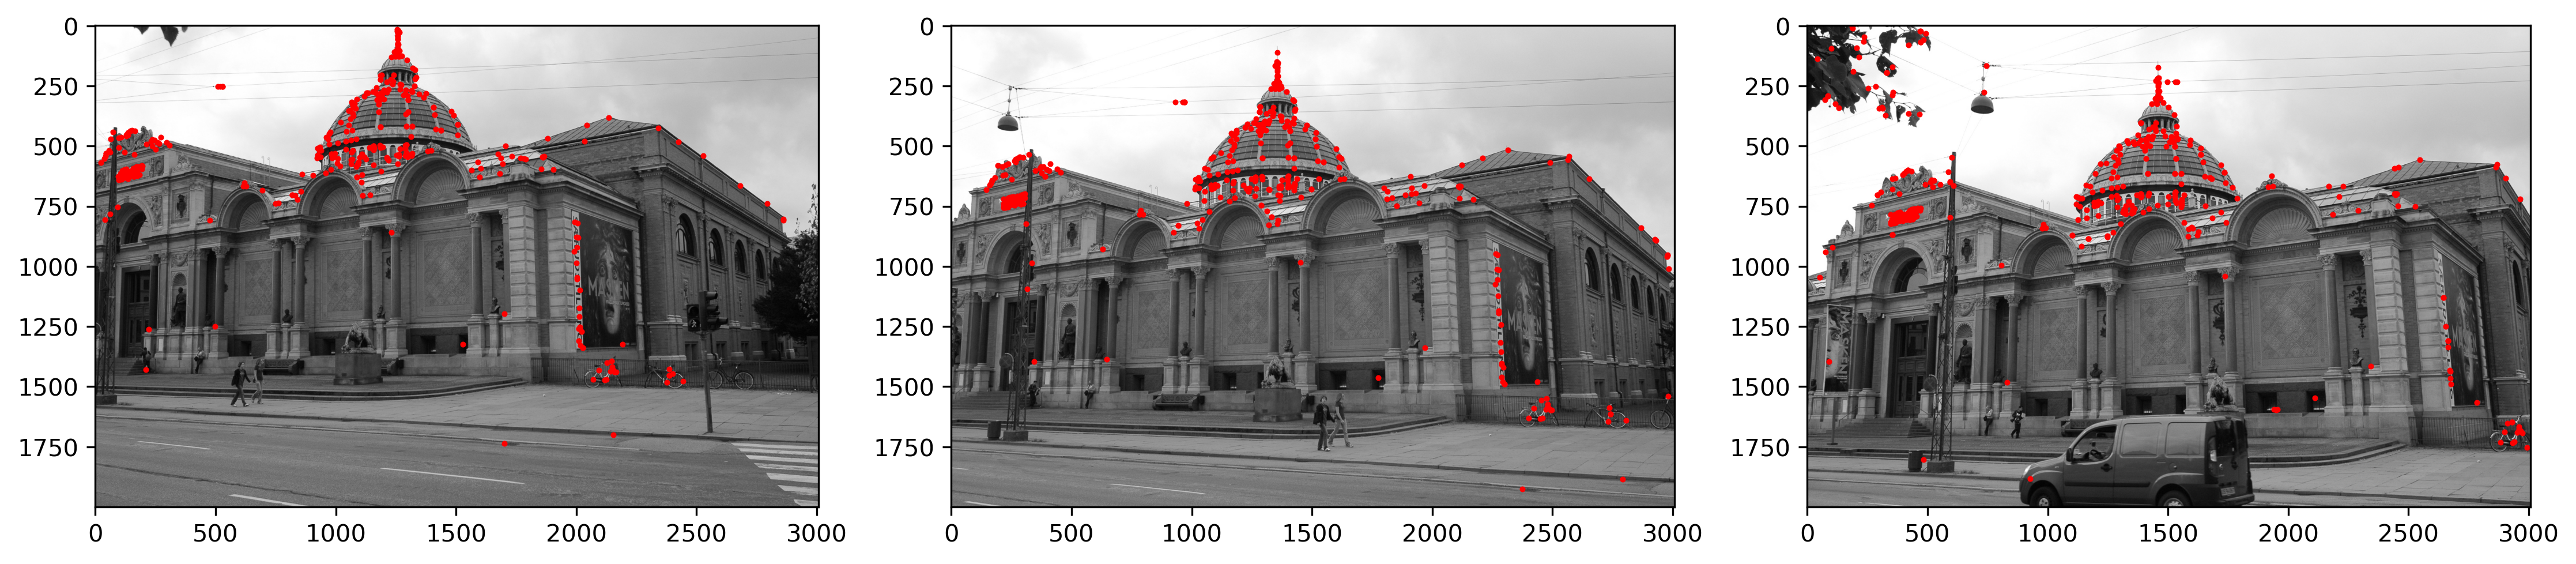

In [24]:
fig, ax = plt.subplots(1,3, figsize=(15,5), dpi=300, tight_layout=True)
ax[0].imshow(im0, cmap='gray')
ax[0].scatter(points0[:,0], points0[:,1], s=2, c='r')
ax[1].imshow(im1, cmap='gray')
ax[1].scatter(points1[:,0], points1[:,1], s=2, c='r')
ax[2].imshow(im2, cmap='gray')
ax[2].scatter(points2[:,0], points2[:,1], s=2, c='r');

In [60]:
# 11.4
distCoeffs = np.zeros(5)
P0 = K @ np.concatenate((np.eye(3), np.zeros((3,1))), axis=1)
P1 = K @ np.concatenate((R1, t1), axis=1)
Q = cv2.triangulatePoints(P0, P1, points0.T, points1.T)
Q = Pi(Q)
Q *= np.sign(Q[2])
_, rvec, tvecs, inliers = cv2.solvePnPRansac(Q.T, points2, K, distCoeffs)
rvec = cv2.Rodrigues(rvec)[0]

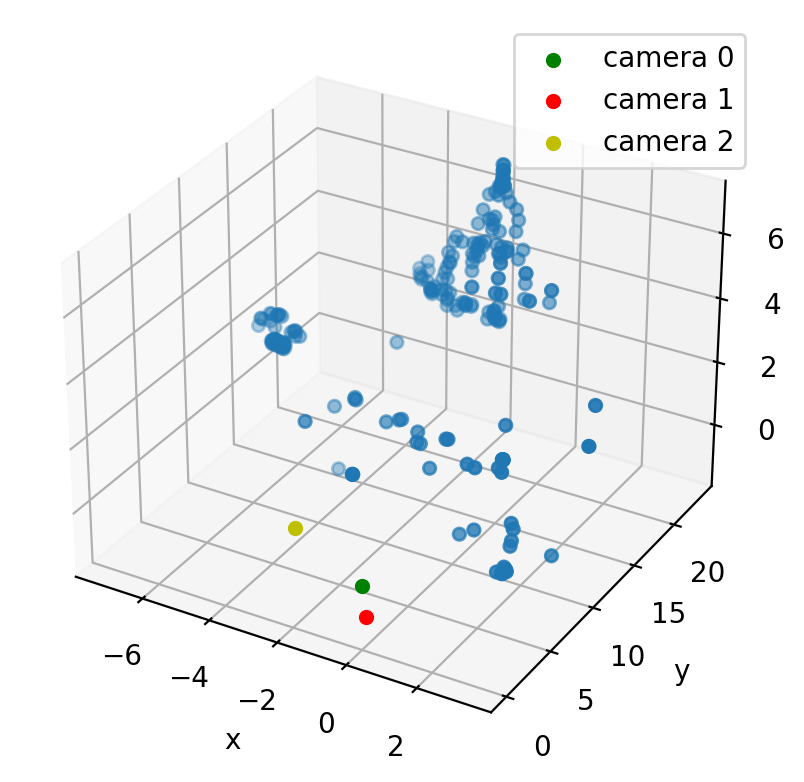

In [73]:
%matplotlib inline
# %matplotlib qt
fig = plt.figure(dpi=200)
ax = fig.add_subplot(projection='3d')
space_points = Q.T[inliers.flatten()].T
ax.scatter(space_points[0,:], space_points[2,:], -space_points[1,:]);
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z');
# plot the cameras
orientation = rvec.T
position = -rvec.T @ t
position = position.flatten()
ax.scatter(0,0,0, color='g',label='camera 0');
ax.scatter(*position, color='r',label='camera 1');
position = -rvec.T @ tvecs
position = position.flatten()
ax.scatter(*position, color='y', label='camera 2');
ax.legend();